In [3]:
pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
df=pd.read_csv("/content/drive/MyDrive/final_category.csv")

In [22]:
train_data=df[:50000]
test_data=df[50000:]


In [23]:
df.shape

(75000, 14)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='all-MiniLM-L6-v2', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline.pkl', model_name='all-MiniLM-L6-v2'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        y = df[target_col]
        preprocessor.fit(X_non_text, y)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


# X_train = process_catalog_df(train_data, target_col='price', test=False)
X_test = process_catalog_df(test_data, target_col='price', test=True)



Non-text pipeline loaded from process_pipeline.pkl


Batches:   0%|          | 0/196 [00:00<?, ?it/s]

In [11]:
X_train.shape


(50000, 395)

In [12]:
X_test.shape

(25000, 395)

In [13]:
Y_train=train_data["price"]

In [14]:
Y_test=test_data["price"]

In [15]:
print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (50000, 395)
Y train shape: (50000,)
X test shape: (25000, 395)
Y test shape: (25000,)


In [16]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0, posinf=0.0, neginf=0.0)
Y_test = np.nan_to_num(Y_test, nan=0.0, posinf=0.0, neginf=0.0)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.saving import register_keras_serializable
@tf.keras.saving.register_keras_serializable()
def smape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.maximum((tf.abs(y_true) + tf.abs(y_pred)) / 2.0, 1e-3)
    smape = numerator / denominator
    smape = tf.where(tf.math.is_finite(smape), smape, tf.zeros_like(smape))
    return tf.reduce_mean(smape)

params = {
    "num_layers": 4,
    "units_0": 128, "activation_0": "relu", "dropout_0": 0.4,
    "units_1": 128, "activation_1": "LeakyReLU", "dropout_1": 0.2,
    "units_2": 256, "activation_2": "relu", "dropout_2": 0.1,
    "units_3": 512, "activation_3": "relu", "dropout_3": 0.2,
    "optimizer": "rmsprop",
    "learning_rate": 0.0002256574510240418
}

def build_mlp(params, input_dim):
    model = Sequential()
    for i in range(params["num_layers"]):
        units = params[f"units_{i}"]
        activation = params[f"activation_{i}"]
        dropout = params[f"dropout_{i}"]

        model.add(Dense(units, input_dim=input_dim if i == 0 else None))
        if activation.lower() == "leakyrelu":
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='linear'))

    if params["optimizer"].lower() == "rmsprop":
        optimizer = RMSprop(learning_rate=params["learning_rate"])
    else:
        optimizer = tf.keras.optimizers.get(params["optimizer"])(learning_rate=params["learning_rate"])

    model.compile(optimizer=optimizer, loss=smape_loss, metrics=['mae'])
    return model


input_dim = X_train.shape[1]
model = build_mlp(params, input_dim)

callbacks = [

    ModelCheckpoint('best_mlp_smape_model.h5', monitor='val_loss', save_best_only=True, verbose=1),

]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

best_model = tf.keras.models.load_model('best_mlp_smape_model.h5', custom_objects={'smape_loss': smape_loss})
loss, mae = best_model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Best Model SMAPE: {loss:.4f}, MAE: {mae:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7390 - mae: 15.8384
Epoch 1: val_loss improved from inf to 0.97575, saving model to best_mlp_smape_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.7389 - mae: 15.8364 - val_loss: 0.9757 - val_mae: 18.2053
Epoch 2/100
374/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6013 - mae: 13.5960
Epoch 2: val_loss improved from 0.97575 to 0.95528, saving model to best_mlp_smape_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6008 - mae: 13.5847 - val_loss: 0.9553 - val_mae: 18.9893
Epoch 3/100
370/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5597 - mae: 12.8619
Epoch 3: val_loss improved from 0.95528 to 0.85398, saving model to best_mlp_smape_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5591 - mae: 12.8605 - val_loss: 0.8540 - val_mae: 19.1259
Epoch 4/100
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5209 - mae: 12.9439
Epoch 4: val_loss improved from 0.85398 to 0.80040, saving model to best_mlp_smape_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5209 - mae: 12.9441 - val_loss: 0.8004 - val_mae: 19.7356
Epoch 5/100
373/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5005 - mae: 13.3411
Epoch 5: val_loss did not improve from 0.80040
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5004 - mae: 13.3262 - val_loss: 0.8598 - val_mae: 20.1762
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4850 - mae: 12.8392
Epoch 6: val_loss did not improve from 0.80040
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4850 - mae: 12.8397 - val_loss: 0.8522 - val_mae: 20.0991
Epoch 7/100
376/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4780 - mae: 12.7804
Epoch 7: val_loss did not improve from 0.80040
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4779 - mae: 12.7841 - val_loss: 0.8333 - val_mae: 19.8394
Epoch 8/100
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4705 - mae: 12.6271
Epoch 8: val_loss did not improve from 0.80040
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

✅ Best Model SMAPE: 0.8004, MAE: 19.7356


## EPOCHS -100 , DATA :50K , EMBEDDINGS :384, NUMERIC :11 : SMAPE: 0.80

## NOW FULL ON DATA AND 784 EMBEDDINGS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='stsb-roberta-base', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline_75k.pkl', model_name='stsb-roberta-base'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        y = df[target_col]
        preprocessor.fit(X_non_text, y)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


X_train = process_catalog_df(df, target_col='price', test=False)
# X_test = process_catalog_df(test_data, target_col='price', test=True)



Non-text pipeline saved to process_pipeline_75k.pkl


Batches:   0%|          | 0/586 [00:00<?, ?it/s]

In [30]:
X_train.shape

(75000, 779)

In [31]:
Y_train=df["price"]

In [32]:
print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)


X train shape: (75000, 779)
Y train shape: (75000,)


In [33]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
Y_train = np.nan_to_num(Y_train, nan=0.0, posinf=0.0, neginf=0.0)


## TRAIN MODEL ON FULL 75K ROWS AND 778 EMBEDDINGS

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.saving import register_keras_serializable
@tf.keras.saving.register_keras_serializable()
def smape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    numerator = tf.abs(y_true - y_pred)
    denominator = tf.maximum((tf.abs(y_true) + tf.abs(y_pred)) / 2.0, 1e-3)
    smape = numerator / denominator
    smape = tf.where(tf.math.is_finite(smape), smape, tf.zeros_like(smape))
    return tf.reduce_mean(smape)

params = {
    "num_layers": 4,
    "units_0": 128, "activation_0": "relu", "dropout_0": 0.4,
    "units_1": 128, "activation_1": "LeakyReLU", "dropout_1": 0.2,
    "units_2": 256, "activation_2": "relu", "dropout_2": 0.1,
    "units_3": 512, "activation_3": "relu", "dropout_3": 0.2,
    "optimizer": "rmsprop",
    "learning_rate": 0.0002256574510240418
}

def build_mlp(params, input_dim):
    model = Sequential()
    for i in range(params["num_layers"]):
        units = params[f"units_{i}"]
        activation = params[f"activation_{i}"]
        dropout = params[f"dropout_{i}"]

        model.add(Dense(units, input_dim=input_dim if i == 0 else None))
        if activation.lower() == "leakyrelu":
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='linear'))

    if params["optimizer"].lower() == "rmsprop":
        optimizer = RMSprop(learning_rate=params["learning_rate"])
    else:
        optimizer = tf.keras.optimizers.get(params["optimizer"])(learning_rate=params["learning_rate"])

    model.compile(optimizer=optimizer, loss=smape_loss, metrics=['mae'])
    return model


input_dim = X_train.shape[1]
model = build_mlp(params, input_dim)

callbacks = [

    ModelCheckpoint('best_mlp_smape_model_75k_778features.h5', monitor='val_loss', save_best_only=True, verbose=1),

]

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

best_model = tf.keras.models.load_model('best_mlp_smape_model_75k_778features.h5', custom_objects={'smape_loss': smape_loss})
loss, mae = best_model.evaluate(X_test, Y_test, verbose=0)
print(f"✅ Best Model SMAPE: {loss:.4f}, MAE: {mae:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6999 - mae: 15.5473
Epoch 1: val_loss improved from inf to 0.56087, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.6997 - mae: 15.5448 - val_loss: 0.5609 - val_mae: 12.7292
Epoch 2/100
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5616 - mae: 13.1828
Epoch 2: val_loss improved from 0.56087 to 0.54865, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5615 - mae: 13.1762 - val_loss: 0.5486 - val_mae: 12.6325
Epoch 3/100
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5383 - mae: 12.8164
Epoch 3: val_loss did not improve from 0.54865
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5381 - mae: 12.8182 - val_loss: 0.5741 - val_mae: 13.0073
Epoch 4/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5243 - mae: 12.7883
Epoch 4: val_loss improved from 0.54865 to 0.49406, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5242 - mae: 12.7884 - val_loss: 0.4941 - val_mae: 12.2824
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5082 - mae: 12.8388
Epoch 5: val_loss improved from 0.49406 to 0.49120, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5082 - mae: 12.8386 - val_loss: 0.4912 - val_mae: 12.0744
Epoch 6/100
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5052 - mae: 12.7026
Epoch 6: val_loss did not improve from 0.49120
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5052 - mae: 12.7025 - val_loss: 0.5045 - val_mae: 12.2520
Epoch 7/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4975 - mae: 12.6433
Epoch 7: val_loss did not improve from 0.49120
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4975 - mae: 12.6425 - val_loss: 0.5256 - val_mae: 12.5847
Epoch 8/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4920 - mae: 12.3042
Epoch 8: val_loss did not improve from 0.49120
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4920 - mae: 12.3049 - val_loss: 0.5190 - val_mae: 12.2518
Epoch 9/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4879 - mae: 12.5082
Epoch 9: val_loss improved from 0.49120 to 0.48690, saving model to best_mlp_smape_model_75

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4879 - mae: 12.5058 - val_loss: 0.4869 - val_mae: 11.8455
Epoch 10/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4812 - mae: 12.1672
Epoch 10: val_loss improved from 0.48690 to 0.48417, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4812 - mae: 12.1680 - val_loss: 0.4842 - val_mae: 11.7138
Epoch 11/100
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4776 - mae: 12.3248
Epoch 11: val_loss did not improve from 0.48417
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4775 - mae: 12.3161 - val_loss: 0.5621 - val_mae: 12.6370
Epoch 12/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4749 - mae: 11.9709
Epoch 12: val_loss did not improve from 0.48417
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4749 - mae: 11.9710 - val_loss: 0.5114 - val_mae: 11.9300
Epoch 13/100
451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4662 - mae: 11.8684
Epoch 13: val_loss improved from 0.48417 to 0.46596, saving model to best_mlp_smape_model_75k_778features.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4663 - mae: 11.8701 - val_loss: 0.4660 - val_mae: 11.1815
Epoch 14/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4687 - mae: 11.7414
Epoch 14: val_loss did not improve from 0.46596
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4687 - mae: 11.7414 - val_loss: 0.4823 - val_mae: 11.3045
Epoch 15/100
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4616 - mae: 11.4998
Epoch 15: val_loss did not improve from 0.46596
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4616 - mae: 11.5027 - val_loss: 0.4870 - val_mae: 11.1785
Epoch 16/100
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4611 - mae: 11.4569
Epoch 16: val_loss did not improve from 0.46596
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4611 - mae: 11.4567 - val_loss: 0.4901 - val_mae: 11.0929
Epoch 17/100
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4603 - mae: 11.4881
Epoch 17: val_loss did not improve from 0.46596
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4340 - mae: 10.8321 - val_loss: 0.4569 - val_mae: 9.9069
Epoch 30/100
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4307 - mae: 10.4686
Epoch 30: val_loss did not improve from 0.45687
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4307 - mae: 10.4726 - val_loss: 0.4719 - val_mae: 10.1823
Epoch 31/100
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4310 - mae: 10.7290
Epoch 31: val_loss did not improve from 0.45687
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4310 - mae: 10.7294 - val_loss: 0.5361 - val_mae: 11.1007
Epoch 32/100
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4331 - mae: 10.7424
Epoch 32: val_loss did not improve from 0.45687
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4331 - mae: 10.7427 - val_loss: 0.4790 - val_mae: 10.2627
Epoch 33/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4284 - mae: 10.7306
Epoch 33: val_loss did not improve from 0.45687
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/s

NameError: name 'Y_test' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation metrics from a Keras model history.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    metric_keys = [k for k in history.history.keys() if 'mae' in k.lower()]
    if metric_keys:
        plt.subplot(1, 2, 2)
        plt.plot(history.history[metric_keys[0]], label='Train MAE', linewidth=2)
        val_metric = [k for k in metric_keys if k.startswith('val_')]
        if val_metric:
            plt.plot(history.history[val_metric[0]], label='Validation MAE', linewidth=2, linestyle='--')
        plt.title('Model MAE Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


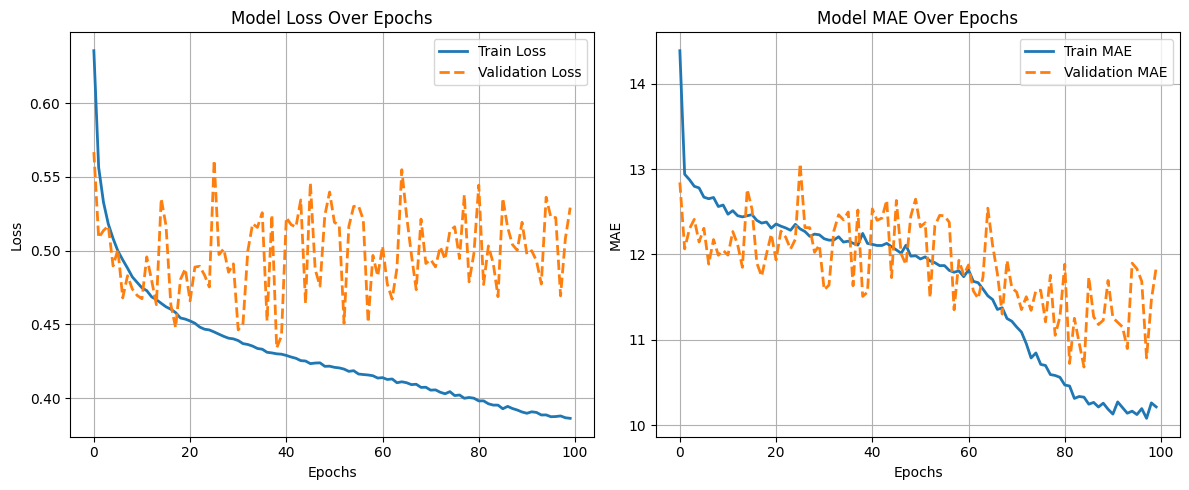

In [25]:
plot_training_history(history)

## EVALUATION ON TEST DATA

In [1]:
import pandas as pd

In [2]:
test_df=pd.read_csv("/content/drive/MyDrive/final_test_with_category.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sentence_transformers import SentenceTransformer
import joblib

numeric_features = [
    'unit_qty', 'pack_count', 'total_qty',
    'num_bullet_points', 'num_product_desc',
    'total_chars_bullet_points', 'total_chars_product_desc', 'avg_bullet_point_len'
]

categorical_features = ['unit', 'brand_name',"category"]
text_feature = 'catalog_content'


def build_preprocessor():
    return ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(cols=categorical_features, handle_unknown='impute'), categorical_features)
    ])


def generate_text_embeddings(df, model_name='stsb-roberta-base', batch_size=128, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    texts = df[text_feature].astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, device=device)
    return np.array(embeddings)


def process_catalog_df(df, target_col='price', test=False, pipeline_path='process_pipeline_75k.pkl', model_name='stsb-roberta-base'):
    if not test:
        preprocessor = build_preprocessor()
        X_non_text = df[numeric_features + categorical_features]
        preprocessor.fit(X_non_text)
        joblib.dump(preprocessor, pipeline_path)
        print(f"Non-text pipeline saved to {pipeline_path}")
    else:
        preprocessor = joblib.load(pipeline_path)
        print(f"Non-text pipeline loaded from {pipeline_path}")

    X_non_text_processed = preprocessor.transform(df[numeric_features + categorical_features])

    text_embeddings = generate_text_embeddings(df, model_name=model_name)

    X_processed = np.hstack((X_non_text_processed, text_embeddings))
    return X_processed


# X_train = process_catalog_df(train_data, target_col='price', test=False)
X_test = process_catalog_df(test_df, target_col='price', test=True)



Non-text pipeline loaded from process_pipeline_75k.pkl


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/672 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/586 [00:00<?, ?it/s]

In [10]:
X_test.shape

(75000, 779)

In [41]:
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

In [12]:
from tensorflow.keras.models import load_model

In [15]:
model=load_model("/content/best_mlp_smape_model_75k_778features.h5",compile=False)

In [42]:
y_pred=model.predict(X_test)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [43]:
print(np.isnan(y_pred).sum())

0


In [54]:
test_df["sample_id"].values

array([100179, 245611, 146263, ..., 162217, 230487, 279477])

In [57]:
pd.DataFrame(y_pred)

,0
0,5.220951
1,6.624385
2,4.761333
3,2.427975
4,6.651126
...,...
74995,3.821800
74996,9.073471
74997,3.845964
74998,5.863500


In [59]:
test_out=pd.DataFrame({"sample_id":test_df["sample_id"].values,"price":y_pred.flatten()})

In [61]:
test_out.isnull().sum()

,0
sample_id,0
price,0


In [62]:
test_out.to_csv("test_out.csv",index=False)